IMPORT

In [1]:
import math
import numpy as np
import pandas as pd
import pickle
import os
import cv2
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import signal, fftpack, stats
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from utils import findStimulationData, dict2array
from wavelet import findWavelets, normalizeFrames
from matplotlib.patches import Ellipse



Define Data Analysis Related Functions

In [3]:
def load_data(xp):
    '''
    Load data from an experiment (xp)
    
    Returns
    ------
    gen_dict
        General info on data (on/off periods, collisions...)
    
    data
        Raw data
    
    metadata
        Raw metadata
    '''
    
    # Load gendict
    genDict = np.load(f'../CoBar-Dataset/{xp}/U3_f/genotype_dict.npy', allow_pickle=True).item()
    
    # Load data
    with open(f'../CoBar-Dataset/{xp}/U3_f/{xp}_U3_f_trackingData.pkl', 'rb') as f:
        data = pickle.load(f)
    
    print(f'{xp} - Data dimension: {data.shape}')
    
    # Extract metadata
    metadata = np.array([list(item) for item in data.index.values])
    print(f'{xp} - Metadata dimension: {metadata.shape}')
    
    return genDict, data, metadata


def findOnPeriods(key, raw_metadata, display=False):
    '''
    Find On-Stimulation periods for a given experiment
    
    Parameters
    ------
    key
        Experiment key
    
    raw_metadata
        Raw metadata for each fly in each experiment
    
    display
        If true, displays on-stimulation intervals
    
    Returns
    ------
    numpy.ndarray
        All frames where the stimulation was ON
    '''
    
    metadata = raw_metadata[key]
    on_periods = ['on0', 'on1', 'on2']

    on_intervals = []

    for p in on_periods:
        start_period = np.where(metadata[:,1] == p)[0][0]
        end_period = np.where(metadata[:,1] == p)[0][-1]
        on_intervals.extend(list(range(start_period, end_period)))
        if display:
            print(f'{p}: {[start_period, end_period]}')
    return np.array(on_intervals)


def get_data_per_fly_per_xp():  
    '''
    Extract data for each fly in each experiment
    
    N: number of flies
    L: number of frames
    
    Returns
    ------
    dict_pretarsi_data
        A dictionary containing xy data for each pretarsus for each fly, size Lx12 for each fly
        key = experiment + fly index (according to tracking video)
    
    dict_metadata
        Corresponding metadata, size Lx6 for each fly
        key = experiment + fly index (according to tracking video)
    
    dict_pos_data
        Centroid xy data, size Lx2 for each fly
        key = experiment + fly index (according to tracking video)
    
    n_trial_data
        Get number of flies in each experiment
        key = experiment
    '''
    
    dict_pretarsi_data = {}
    dict_metadata = {}
    dict_pos_data = {}
    n_trial_data = {}
    
    stim_col = 1 # Metadata column with stimulation info ('on'/'off')
    xp_col = 3   # Metadata column with experiment info (time of experiment)
    fly_col = 4  # Metadata column with fly info (fly 0, 1 or 2) 
    
    for strain in transgenics:
        # Load data for given strain
        genDict, data, metadata = load_data(strain)
        
        # Extract pretarsi data
        pretarsi = ["LFclaw", "LHclaw", "LMclaw", "RFclaw", "RHclaw", "RMclaw"]
        pos = ["posx", "posy"]
        orientation = ["orientation"]
        pretarsi_data = data[pretarsi]   
        pos_data = data["center"][pos + orientation]
    
        # Gather all possible experiments and maximum number of flies
        xps = np.unique(metadata[:,xp_col])
        flies = np.unique(metadata[:,fly_col])
        
        n_trials = len(xps)*len(flies)

        for xp in xps:
            # Extract rows corresponding to current experiment
            xp_idx = np.where(metadata[:,xp_col] == xp)[0]
            
            # Extract corresponding metadata, pretarsi data and positional data
            xp_metadata = metadata[xp_idx]
            xp_pretarsi_data = pretarsi_data.iloc[xp_idx]
            xp_pos_data = pos_data.iloc[xp_idx]

            for fly in flies:
                # Extract rows corresponding to current fly
                fly_idx = np.where(xp_metadata[:,fly_col] == fly)[0]
                
                # Extract corresponding metadata and data for current fly
                xp_fly_metadata = xp_metadata[fly_idx]
                xp_fly_pretarsi_data = xp_pretarsi_data.iloc[fly_idx]
                xp_fly_pos_data = xp_pos_data.iloc[fly_idx]
                
                xp_fly_metadata = np.append(xp_fly_metadata, np.array(range(len(xp_fly_metadata))).reshape(-1,1), axis=1)
                
                
                # Sort timestamps, and re-arrange fly data for time stamps
                # Order = 'off0', 'on0', 'off1', 'on1', 'off2', 'on2', 'off3'
                if not(xp_fly_pretarsi_data.empty):
                    
                    dict_metadata[xp+fly] = np.array(sorted(xp_fly_metadata, key=lambda x: (int(x[stim_col][-1]), x[stim_col])))
                    idx_sort = np.array(list(map(int, dict_metadata[xp+fly][:,-1])))
                    dict_pretarsi_data[xp + fly] = np.array(xp_fly_pretarsi_data)[idx_sort,:] * 38/832                    
                    dict_pos_data[xp + fly] = np.array(xp_fly_pos_data)[idx_sort,:]
                    
                    # Only convert x, y pos positions to mm
                    dict_pos_data[xp + fly][:,:2] *= 38/832
                else:
                    n_trials -= 1
            
        n_trial_data[strain] = n_trials
        
        print(f'{strain}: {n_trials} trials')
    
    return dict_pretarsi_data, dict_metadata, dict_pos_data, n_trial_data


def findStimulationData(raw_pretarsi_data, raw_metadata):
    '''
    Extract data where the stimulation was ON
    
    raw_pretarsi_data
        Raw xy data for each pretarsus, size Lx12 for each fly
    
    raw_metadata
        Corresponding metadata, size Lx6 for each fly
    
    Returns
    ------
    stim_data
        XY stimulation data for each pretarsus, size lx12 for each fly, l < L
    '''
    stim_data = {}
    
    for key, data in raw_pretarsi_data.items():
        on_idxs = findOnPeriods(key, raw_metadata)
        
        stim_data[key] = data[on_idxs,:]
        
    return stim_data


def runPipeline(raw_pretarsi_data, raw_metadata, n_trial_data, 
                groupByFly=False, decimate=False, pca=False):
    stim_data = findStimulationData(raw_pretarsi_data, raw_metadata)
    print(f'Stimulation data - number of flies: {len(stim_data)}')
    print(f'Dimension of an observation {stim_data[next(iter(stim_data))].shape} \n')
    
    print('Wavelet transformation...')
    wavelet_data = findWavelets(stim_data)
    print('Wavelet transform: Done')

    normalized_wavelet_data = normalizeFrames(wavelet_data)
    print('Frame normalization: Done')
    
    normalized_wavelet_array, min_nFrames = dict2array(normalized_wavelet_data, nCoords=40, 
                                                   groupByFly=groupByFly, decimate=decimate)
    print(f'Conversion to array - data shape: {normalized_wavelet_array.shape} \n')
    
    if pca:
        print('PCA decomposition...')
        normalized_wavelet_array = PCA(n_components=0.9, random_state=42).fit_transform(normalized_wavelet_array)
        print(f'Number of features kept to explain 90% of variance: {normalized_wavelet_array.shape[1]} \n')
    
    return normalized_wavelet_array, min_nFrames




Define Plotting Related Functions

In [5]:
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))

Retrieve folders for transgenic strains:

In [6]:
transgenics = os.listdir('../CoBar-Dataset')
transgenics.remove('PR') # Control

Get data fly-based data:

In [7]:
raw_pretarsi_data, raw_metadata, _, n_trial_data = get_data_per_fly_per_xp()

MDN - Data dimension: (28770, 70)
MDN - Metadata dimension: (28770, 6)
MDN: 12 trials
SS01049 - Data dimension: (26385, 70)
SS01049 - Metadata dimension: (26385, 6)
SS01049: 11 trials
SS01054 - Data dimension: (31162, 70)
SS01054 - Metadata dimension: (31162, 6)
SS01054: 13 trials
SS01540 - Data dimension: (26361, 70)
SS01540 - Metadata dimension: (26361, 6)
SS01540: 11 trials
SS02111 - Data dimension: (26396, 70)
SS02111 - Metadata dimension: (26396, 6)
SS02111: 11 trials
SS02279 - Data dimension: (28776, 70)
SS02279 - Metadata dimension: (28776, 6)
SS02279: 12 trials
SS02377 - Data dimension: (28764, 70)
SS02377 - Metadata dimension: (28764, 6)
SS02377: 12 trials
SS02608 - Data dimension: (28740, 70)
SS02608 - Metadata dimension: (28740, 6)
SS02608: 12 trials
SS02617 - Data dimension: (26355, 70)
SS02617 - Metadata dimension: (26355, 6)
SS02617: 11 trials


apply wavelet transform and PCA:

In [8]:
normalized_wavelet_array, min_nframes = runPipeline(raw_pretarsi_data, raw_metadata, n_trial_data, 
                groupByFly=True, decimate=False, pca=True)

Stimulation data - number of flies: 105
Dimension of an observation (716, 12) 

Wavelet transformation...
Wavelet transform: Done
Frame normalization: Done
Conversion to array - data shape: (105, 168960) 

PCA decomposition...
Number of features kept to explain 90% of variance: 67 



Extract classes for each fly (1 = MDN, 2 = SS01049...):

In [9]:
classes = [] # List of colours attributed to each strain for later plotting
strains = [] # Strain corresponding to each fly
unique_classes = [] # Unique version of 'classes'

for i, key in enumerate(n_trial_data.keys()):
    unique_classes.append(sns.color_palette()[i])
    for j in range(n_trial_data[key]):
        classes.append(sns.color_palette()[i])
        strains.append(key)
        
unique_classes = np.array(unique_classes)
classes = np.array(classes)
strains = np.array(strains)

Perform GMM clustering:

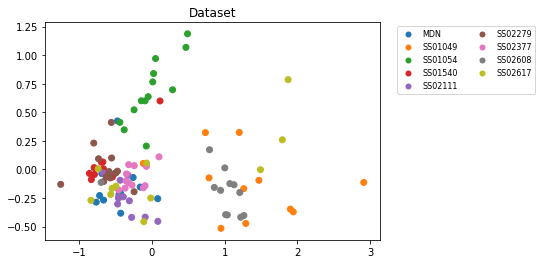

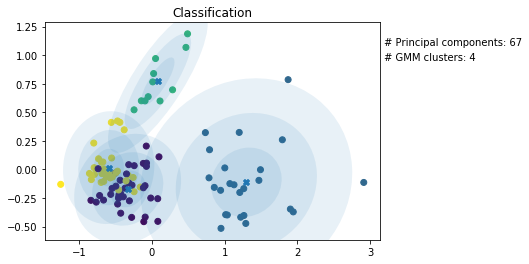

MDN [3 0 3 3 0 0 0 0 0 0 3 0]
SS01049 [1 1 1 0 1 1 1 1 1 1 1]
SS01054 [2 2 2 2 2 3 2 2 3 2 2 0 2]
SS01540 [3 3 3 3 3 3 3 2 3 3 3]
SS02111 [0 0 0 0 0 3 0 0 0 0 3]
SS02279 [3 3 3 3 3 3 3 3 3 3 3 3]
SS02377 [0 0 0 0 0 3 0 0 0 0 3 0]
SS02608 [1 1 1 1 1 1 1 1 1 1 3 1]
SS02617 [0 0 0 1 0 1 0 0 1 0 0]


In [12]:
#CHOOSE NUMBER OF CLUSTERS
GMM_comp = 4


#GMM Clustering
X        = normalized_wavelet_array
gmm = GaussianMixture(n_components = GMM_comp, max_iter = 100, random_state = 1)
X_label = gmm.fit_predict(X)

#Extract projected means and cov on 2 first eigenvectors
means_2d = gmm.means_[:,0:2]
cov_2d = gmm.covariances_[:,0:2, 0:2]

#==================================PLOTTING==============================================#
plt.title("Dataset")
plt.scatter(X[:,0], X[:,1], c = classes, label = strains)
lp = lambda i: plt.plot([], color=unique_classes[i], mec="none",
                        label=list(n_trial_data.keys())[i], ls="", marker="o")[0]
handles = [lp(i) for i in np.arange(len(np.unique(strains)))]
plt.legend(handles=handles, ncol=2, prop={'size': 8}, bbox_to_anchor=(1.04,1), loc="upper left")
plt.savefig("dataset.png", bbox_inches = 'tight')
plt.show()


plt.title("Classification")
plt.scatter(X[:, 0], X[:,1], c = X_label)
plt.scatter(means_2d[:,0], means_2d[:,1], marker = 'X')
plt.gcf().text(0.91, 0.8, "# Principal components: " + str(67), fontsize=10)
plt.gcf().text(0.91, 0.75, "# GMM clusters: " + str(GMM_comp), fontsize=10)

for i in range(means_2d.shape[0]):
    center = means_2d[i,:]
    cov = cov_2d[i,:,:]
    draw_ellipse(center, cov, alpha=0.1)
plt.savefig("clustering_PCA_GMM_rs"+str(GMM_comp) + ".png", bbox_inches = 'tight')
plt.show()


#Print cluster assignation
for i, strain in enumerate(np.unique(strains)): 
    print(strain, X_label[(strains == strain)])
